In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


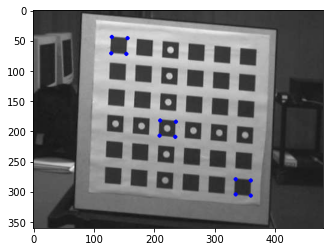

In [3]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [4]:
print(front_2Dcoord)

[[130.207   44.2962]
 [156.3471  46.5892]
 [154.9713  72.7293]
 [129.2898  71.3535]
 [210.4618 182.3344]
 [236.1433 184.1688]
 [235.6847 209.8503]
 [209.086  207.0987]
 [335.6592 279.5573]
 [360.4236 281.3917]
 [360.8822 306.1561]
 [335.2006 304.3217]]


In [5]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))
back_3Dcoord = np.zeros((12, 3))
pos = np.array([[0, 0, 0], [50, 0, 0], [50, 50, 0], [0, 50, 0]],
               dtype=np.float32)
_ = np.array([[0, 0, 0], [160, 240, 0], [400, 400, 0]], dtype=np.float32)
for i in range(4):
    for j in range(3):
        front_3Dcoord[j * 4 + i, :] = pos[i] + _[j]
        back_3Dcoord[j * 4 + i, :] = pos[i] + _[j]
        back_3Dcoord[j * 4 + i, 2] = 150

all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_3Dcoord.shape)

(24, 3)


In [6]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------

P = np.zeros((48, 12))
m = np.zeros((12, 1))
for i in range(24):
    P[2 * i, 0:3] = all_3Dcoord[i]
    P[2 * i, 8:11] = -all_2Dcoord[i][0] * all_3Dcoord[i]
    P[2 * i, 3] = 1
    P[2 * i, 11] = -all_2Dcoord[i][0]
    P[2 * i + 1, 4:7] = all_3Dcoord[i]
    P[2 * i + 1, 8:11] = -all_2Dcoord[i][1] * all_3Dcoord[i]
    P[2 * i + 1, 7] = 1
    P[2 * i + 1, 11] = -all_2Dcoord[i][1]
U,sigma,VT=np.linalg.svd(P)
m=VT[11]
#print(sigma)
#print(P)
#print(VT[11])


In [7]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

K = np.zeros((3, 3))
R = np.zeros((3, 3))
T = np.zeros((3, 1))
m = m.reshape((3, 4))
a1 = m[0, 0:3]
a2 = m[1, 0:3]
a3 = m[2, 0:3]
b = m[:, 3]
rou = 1 / np.linalg.norm(a3)
rou_2 = rou**2
u0 = rou_2 * np.dot(a1,a3)
v0 = rou_2 * np.dot(a2,a3)
a1_a3=np.cross(a1,a3)
a2_a3=np.cross(a2,a3)
n13=np.linalg.norm(a1_a3)
n23=np.linalg.norm(a2_a3)
theta_cos = np.dot(a1_a3,a2_a3)/(n13*n23)
theta = np.arccos(theta_cos)
alpha=rou_2*n13*np.sin(theta)
beta = rou_2*n23*np.sin(theta)
r1=a2_a3/n23
r3=a3/np.linalg.norm(a3)
r2 = np.cross(r3, r1)
K = np.array(
    [alpha, alpha / np.tan(theta), u0, 0, beta / np.sin(theta), v0, 0, 0, 1]).reshape((3,3))
T=rou*(np.linalg.inv(K)@b)
R[0,:]=r1
R[1,:]=r2
R[2,:]=r3

In [8]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)